In [1]:
%matplotlib inline
import pandas as pd
import os
from datetime import datetime
import math
import numpy as np
import matplotlib.pyplot as plt

# plotly viz - use matplotlib if you prefer
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# cleanair modules
from cleanair.scoot import ScootQuery

In [2]:
secretfile = "../../terraform/.secrets/db_secrets.json"

# choose a start and end date for this query
start_datetime="2020-03-23 00:00:00"
end_datetime="2020-03-25 00:00:00"

# columns to analyse
columns = ["n_vehicles_in_interval", "occupancy_percentage", "congestion_percentage", "saturation"]

SQ = ScootQuery(secretfile=secretfile)

2020-03-26 22:01:32     INFO: Database connection information loaded from <_io.TextIOWrapper name='../../terraform/.secrets/db_secrets.json' mode='r' encoding='UTF-8'>


# Detector readings
Get all scoot observations between `start_datetime` and `end_datetime`

In [3]:
all_df = SQ.get_all_readings(start_datetime=start_datetime, end_datetime=end_datetime)

In [4]:
all_df.columns

Index(['detector_id', 'lon', 'lat', 'measurement_start_utc',
       'measurement_end_utc', 'n_vehicles_in_interval', 'occupancy_percentage',
       'congestion_percentage', 'saturation'],
      dtype='object')

# Simple Data cleaning

    - Convert Datetime to epoch
    - Add normalised/standardised columns

In [5]:
def normalise(x):
    """Standardize all columns individually"""
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def denormalise(x, wrt_y):
    """Denormalize x given the original data it was standardized to"""
    return ( x * np.std(wrt_y, axis=0) ) + np.mean(wrt_y, axis=0)

In [6]:
all_df['measurement_start_utc'] = pd.to_datetime(all_df['measurement_start_utc'])
all_df['epoch'] = all_df['measurement_start_utc'].astype('int64')//1e9 #convert to epoch

all_df['epoch_norm'] = normalise(all_df['epoch'])
all_df['lat_norm'] = normalise(all_df['lat'])
all_df['lon_norm'] = normalise(all_df['lon'])

# Helper functions

In [7]:
def get_X(df):
    return np.array(df[['epoch_norm', 'lon_norm', 'lat_norm']])

def get_Y(df):
    return np.array(df[['n_vehicles_in_interval']])

# Jointly train all sensors

The input $X$ is time epoch, lat, lon and output $Y$ is the integer n_vehicles_in_interval

NOTE for 2 days of scoot data there are approx 400000 observations

In [8]:
X = get_X(all_df) #N x D
Y = get_Y(all_df) # N x 1

In [9]:
print(Y.shape)

(477410, 1)


&lt; insert model here &gt;

# Train scoot individually as a time series

In [10]:
scoot_ids = np.unique(all_df['detector_id'])
grouped_df = all_df.groupby('detector_id')

In [11]:
scoot_individual_df_arr = [grouped_df.get_group(scoot_id) for scoot_id in scoot_ids] #array of dfs for all sensors
X_arr = [get_X(df) for df in scoot_individual_df_arr] # |Number of scoot sensors| x N_i x D
Y_arr = [get_Y(df) for df in scoot_individual_df_arr] # |Number of scoot sensors| x N_i x 1

&lt; insert model here &gt;

## Simple Time series plot

/usr/local/anaconda3/envs/clean_air/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



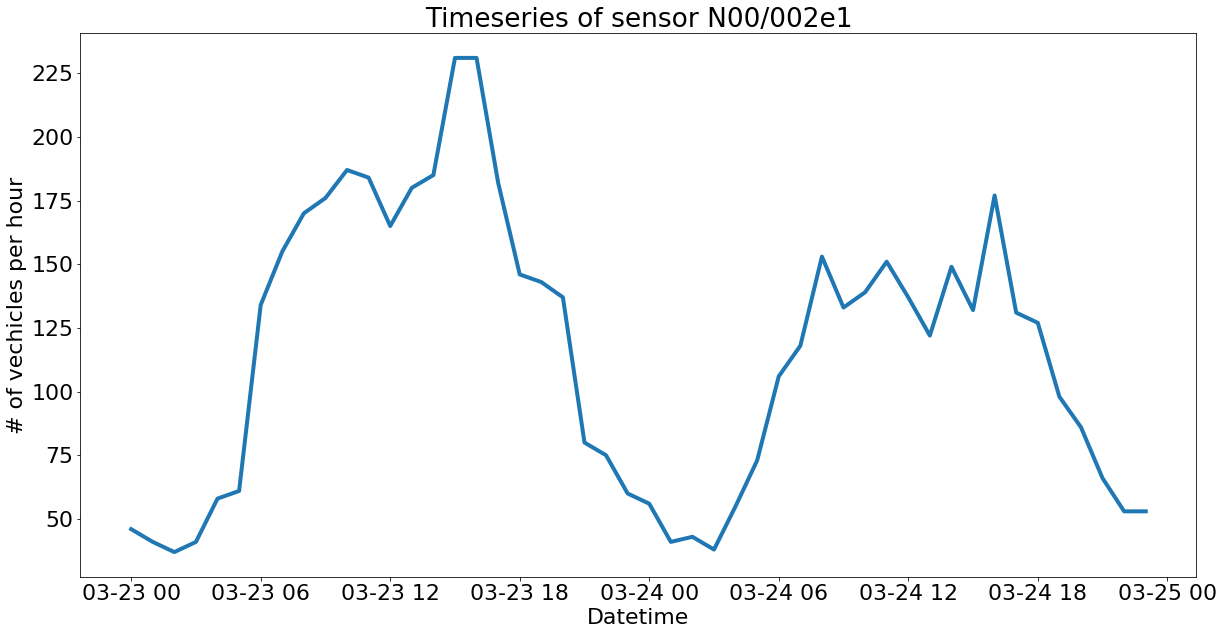

In [12]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
scoot_id = 0
sensor_df = scoot_individual_df_arr[scoot_id]
plt.plot(sensor_df['measurement_start_utc'], sensor_df['n_vehicles_in_interval'], linewidth=4)
plt.title('Timeseries of sensor {scoot_id}'.format(scoot_id=scoot_ids[scoot_id]))
plt.xlabel('Datetime')
plt.ylabel('# of vechicles per hour')
plt.show()